In [1]:
import sys
sys.path.append('../')

In [2]:
# Enable autoreload for external modules
%load_ext autoreload
%autoreload 2

In [3]:
import os
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from util import *

In [4]:
seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [5]:
model_version = 'v16.1'
base_model_version = 'v16.0'

In [6]:
with open('../data_schema_V2.0.json', 'r') as f:
    config = json.load(f)
    
spectro_cols = config['spectro_cols']
photo_cols = config['photometry_cols']
generic_cols = config['generic_cols']
target_col = config['target_col']

In [7]:
df = pd.read_csv(f"../data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols]
y = df[target_col]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed_value)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
input_shape = X_train_scaled.shape[1]

optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.Dropout(0.2, name='Dropout_64')(x)

# Layer 2
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)

# Layer 3
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), name='Dense_256')(x)
x = layers.Dropout(0.2, name='Dropout_256')(x)

# Layer 4
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)

# Layer 5
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='Dense_64_2')(x)
x = layers.Dropout(0.2, name='Dropout_64_2')(x)

# Output layer
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Regression_Model')

model.load_weights(f"../models/{base_model_version}/spec_photo_model.h5", by_name=True, skip_mismatch=True)

model.get_layer('Dense_64').trainable = False
model.get_layer('Dense_128').trainable = False
model.get_layer('Dense_256').trainable = True
model.get_layer('Dense_128_2').trainable = True

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.mean_squared_error, 
              metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 10)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                704       
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 Dense_256 (Dense)           (None, 256)               33024     
                                                                 
 Dropout_256 (Dropout)       (None, 256)          

In [11]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.5, verbose=1, callbacks=[early_stopping])

Epoch 1/200
2438/2438 [==============================] - 28s 11ms/step - loss: 0.4416 - mae: 0.4628 - mse: 0.3652 - mape: 4.4508 - val_loss: 0.2694 - val_mae: 0.3446 - val_mse: 0.2031 - val_mape: 3.3239
Epoch 2/200
2438/2438 [==============================] - 36s 15ms/step - loss: 0.3754 - mae: 0.4275 - mse: 0.3132 - mape: 4.1235 - val_loss: 0.2485 - val_mae: 0.3267 - val_mse: 0.1900 - val_mape: 3.1538
Epoch 3/200
2438/2438 [==============================] - 36s 15ms/step - loss: 0.3526 - mae: 0.4132 - mse: 0.2976 - mape: 3.9932 - val_loss: 0.2500 - val_mae: 0.3282 - val_mse: 0.1975 - val_mape: 3.2056
Epoch 4/200
2438/2438 [==============================] - 36s 15ms/step - loss: 0.3533 - mae: 0.4111 - mse: 0.3019 - mape: 3.9760 - val_loss: 0.2879 - val_mae: 0.3422 - val_mse: 0.2206 - val_mape: 3.3741
Epoch 5/200
2438/2438 [==============================] - 36s 15ms/step - loss: 0.3478 - mae: 0.4033 - mse: 0.2854 - mape: 3.9030 - val_loss: 0.2585 - val_mae: 0.3386 - val_mse: 0.2014 - va

In [12]:
model.save(f"../models/{model_version}/photo_only_model.h5")

In [13]:
save_history(history, model_version, history_name='history_photo_only')

In [14]:
y_pred = model.predict(X_test_scaled)

2090/2090 [==============================] - 3s 1ms/step


In [15]:
plot_metrics(y_test, y_pred)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.3071
Root Mean Squared Error (RMSE): 0.4163
R² Score: 0.5913


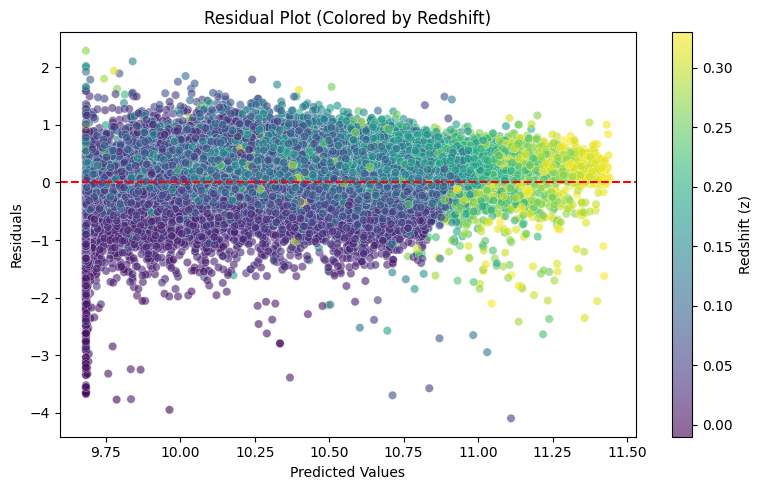

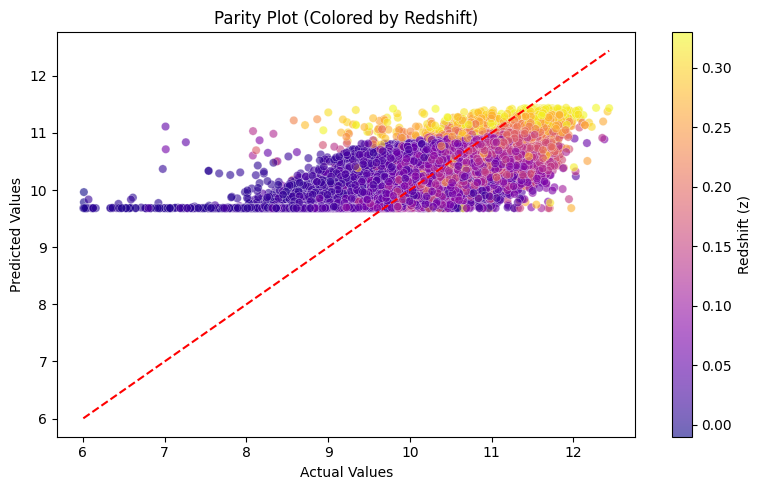

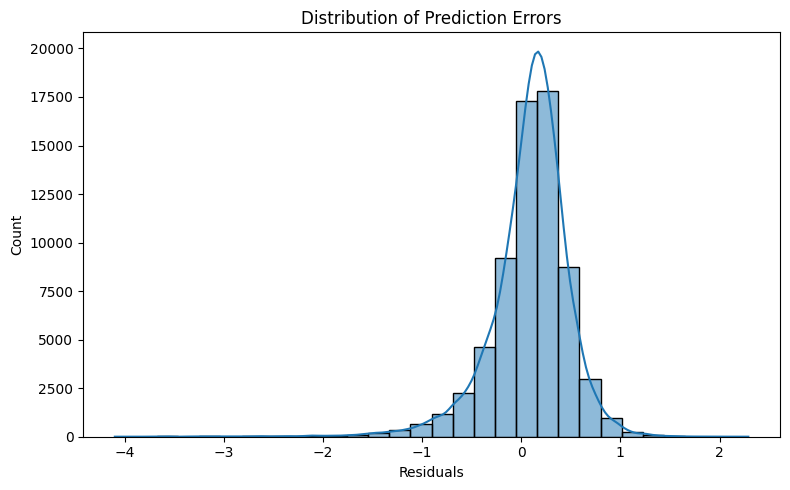

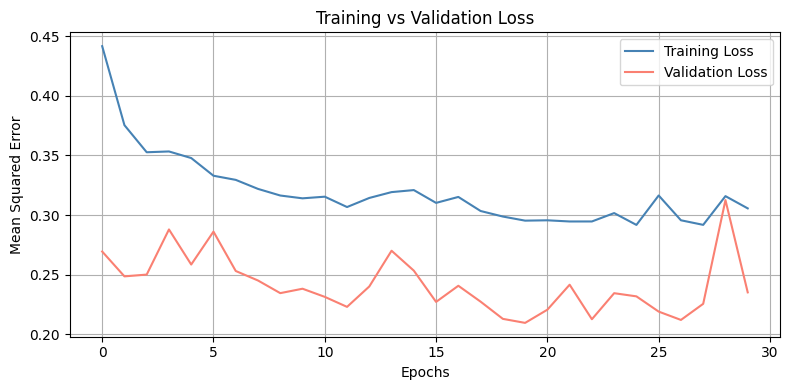

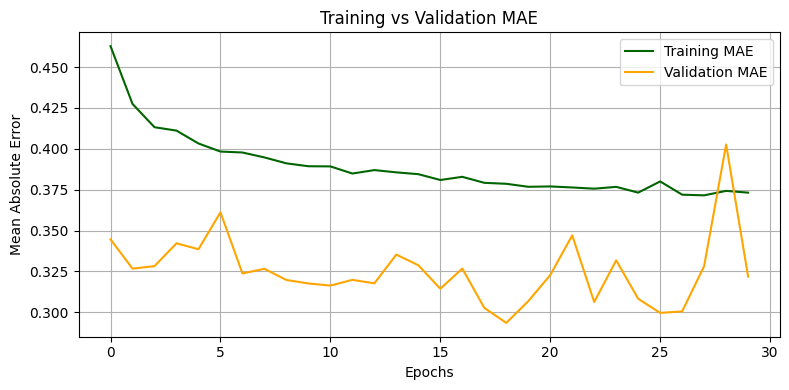

In [16]:
plot_visualizations(y_test, y_pred, z_values=X_test['z'], history=history)